## Runs DE on different clusters. Also runs DE within each cluster for each condition.
Does this over each donor and combined

In [1]:
# Input info
se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/se_cells_meta.tsv"
p_thresh = 0.1 
out_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/hypergeom_clone_clust/mincl.10_bothConds.False_p0.1/hypergeom.csv"

min_clone_size = 10

conds_sep = False

In [2]:
import pandas as pd
import numpy as np
from os.path import join
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

In [3]:
cells_meta = pd.read_csv(se_cells_meta_f, sep="\t")
cells_meta = cells_meta.loc[~(cells_meta["name"]=="None")]
sizes = cells_meta.groupby("name").size().sort_values(ascending=False)

if conds_sep:
    name_cond_size = cells_meta.groupby(["name","condition"]).size()
    name_cond_size = name_cond_size[name_cond_size>min_clone_size].reset_index()
    tmp = name_cond_size.groupby("name").size()>1
    clones_filt = tmp[tmp==True].index #sizes.loc[tmp[tmp==True].index]

else:
    name_cond_size = cells_meta.groupby(["name"]).size()
    name_cond_size = name_cond_size[name_cond_size>min_clone_size]
    clones_filt = name_cond_size.index 

sizes = sizes.loc[clones_filt].sort_values(ascending=False)
clones_filt

groups = cells_meta.groupby(["seurat_clusters", "name"]).size().reset_index().rename({0:"count"}, axis=1)
groups

clones = clones_filt#np.unique(groups["name"])
clones

atac_cl = np.unique(groups["seurat_clusters"])
atac_cl

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [4]:
#p(k,M,n,N) = (n choose k)((M-n)choose(N-k))/(MchooseN)
#pmf(k, M, n, N) = choose(n, k) * choose(M - n, N - k) / choose(M, N),
                               #for max(0, N - (M-n)) <= k <= min(n, N)
    
# M: Total number of cells
# n: Number of cells in the atac cluster (group population)
# N: Number of cells in clone (the draw)
# x: Number of cells in specific clone and cluster
enrichment_df = pd.DataFrame(index=clones,
                             columns=atac_cl, dtype=np.float128)

M = groups["count"].sum()
for cl in clones:
    for atac in atac_cl:     
        n = groups[groups["seurat_clusters"]==atac]["count"].sum()
        N = groups[groups["name"]==cl]["count"].sum()
        
        x = groups[((groups["name"]==cl)& (groups["seurat_clusters"]==atac))]["count"].sum()
        
        # rv = hypergeom(M, n, N)
        prb = 1 - hypergeom.cdf(x, M, n, N)
        enrichment_df.loc[cl, atac] = prb
        

In [5]:
enrichment_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
name,,,,,,,,,,,,,,,
0_0,8.663030e-01,0.999999,0.000335,7.438091e-10,0.990246,0.980736,0.608249,0.951486,0.981450,8.154029e-01,0.295535,0.261071,0.001536,0.002989,0.010952
0_1,9.999971e-01,0.997607,0.007382,0.000000e+00,0.999998,0.998630,0.999375,0.697784,0.620942,9.958090e-01,0.414296,0.000403,0.004613,0.180186,0.232973
0_10,0.000000e+00,0.041704,1.000000,1.000000e+00,0.221523,0.839671,0.055429,0.323341,0.841041,4.823935e-03,0.000539,0.993793,0.930743,0.976769,0.087506
0_11,9.996564e-01,0.944726,0.000014,0.000000e+00,0.999992,0.976133,0.852554,0.960087,0.952612,9.843362e-01,0.848614,0.005482,0.115569,0.000857,0.800172
0_12,6.800449e-10,0.248765,1.000000,1.000000e+00,0.750361,0.270202,0.000550,0.960087,0.952612,5.759726e-12,0.000012,0.990711,0.984110,0.686881,0.800172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_5,1.009852e-01,0.015357,1.000000,1.000000e+00,0.000001,0.000709,0.377709,0.819113,0.218242,9.464908e-07,0.172813,0.997699,0.991878,0.997392,0.048978
1_6,9.999640e-01,0.999578,0.000001,1.497079e-02,0.007765,0.627638,0.995069,0.012202,0.878562,9.814788e-01,0.998033,0.000317,0.576248,0.817587,0.137477
1_7,9.996899e-01,0.999319,0.000000,5.386419e-04,0.997688,0.734883,0.999398,0.055311,0.196230,9.994447e-01,0.999994,0.000093,0.735572,0.806140,0.130030


In [6]:
reject, pvals_corrected, _, _ = multitest.multipletests(enrichment_df.values.flatten(), alpha=p_thresh, method="fdr_bh")

In [7]:
nrows, ncols = enrichment_df.shape
reject, pvals_corrected, _, _ = multitest.multipletests(enrichment_df.values.flatten(),
                                                        alpha=p_thresh, method="fdr_bh")
pvals_corrected = np.reshape(pvals_corrected, [nrows,ncols])
bh_enrichment_df = enrichment_df.copy()
bh_enrichment_df.loc[:,:] = pvals_corrected
bh_enrichment_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
name,,,,,,,,,,,,,,,
0_0,1.000000e+00,1.000000,0.007580,7.995948e-08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,0.719322,0.683126,0.024160,0.041909,0.099496
0_1,1.000000e+00,1.000000,0.076185,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,0.852378,0.008601,0.058924,0.553429,0.642905
0_10,0.000000e+00,0.242334,1.000000,1.000000e+00,0.623940,1.000000,0.292948,0.755634,1.000000,5.983535e-02,0.010218,1.000000,1.000000,1.000000,0.372551
0_11,1.000000e+00,1.000000,0.000636,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,0.064877,0.428401,0.015138,1.000000
0_12,7.975072e-08,0.666623,1.000000,1.000000e+00,1.000000,0.691589,0.010283,1.000000,1.000000,9.287558e-10,0.000578,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_5,3.965542e-01,0.123045,1.000000,1.000000e+00,0.000076,0.012703,0.818898,1.000000,0.617394,6.426175e-05,0.547737,1.000000,1.000000,1.000000,0.277056
1_6,1.000000e+00,1.000000,0.000071,1.214611e-01,0.079500,1.000000,1.000000,0.105921,1.000000,1.000000e+00,1.000000,0.007296,0.993796,1.000000,0.472922
1_7,1.000000e+00,1.000000,0.000000,1.021835e-02,1.000000,1.000000,1.000000,0.292948,0.581925,1.000000e+00,1.000000,0.002655,1.000000,1.000000,0.452858


In [8]:
output_df = pd.DataFrame(index=sizes.index)
output_df["significant clusters"] = ""
output_df["size"] = sizes
#output_df["min_significance"] = None

sig_results = []
sig_order = []
for ind, val in bh_enrichment_df.loc[sizes.index].iterrows():
    passed = val[val<p_thresh].index.values
    if len(passed)>0:
        output_df.loc[ind, "significant clusters"] = ";".join([str(x) for x in passed])
        output_df.loc[ind, "min_significance"] = min(val)
       # sig_results.append((ind, passed))
output_df.loc[:, bh_enrichment_df.columns] = bh_enrichment_df.loc[output_df.index]
output_df = output_df.sort_values("min_significance")
output_df = output_df.loc[~(output_df["min_significance"].isnull())]
output_df

,significant clusters,size,min_significance,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
name,,,,,,,,,,,,,,,,,,
0_11,2;3;11;13,265,0.000000,1.000000,1.000000,0.000636,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.064877,0.428401,0.015138,1.000000
0_19,2;3,189,0.000000,1.000000,1.000000,0.043006,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.548857,0.339175,0.238328,0.745641
0_10,0;9;10,279,0.000000,0.000000,0.242334,1.000000,1.000000,0.623940,1.000000,0.292948,0.755634,1.000000,0.059835,0.010218,1.000000,1.000000,1.000000,0.372551
0_5,2;3;11;14,298,0.000000,1.000000,1.000000,0.002048,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.002048,0.744249,0.137784,0.088387
0_1,2;3;11;12,410,0.000000,1.000000,1.000000,0.076185,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.852378,0.008601,0.058924,0.553429,0.642905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_28,6,105,0.085686,1.000000,1.000000,0.245997,1.000000,0.770677,0.105808,0.085686,0.372551,1.000000,0.862529,0.762267,0.396554,0.914768,1.000000,0.906269
0_39,13,95,0.085991,0.666623,0.504606,1.000000,0.745641,1.000000,0.516122,0.778768,1.000000,0.284544,1.000000,0.452858,0.914768,0.865824,0.085991,0.875241
0_34,0;12,115,0.085991,0.090970,0.609285,1.000000,0.688927,1.000000,1.000000,1.000000,0.485892,0.800370,0.438583,1.000000,1.000000,0.085991,0.898455,0.929018


In [9]:
output_df.to_csv(out_f, sep=",")

In [11]:
bh_enrichment_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
name,,,,,,,,,,,,,,,
0_0,1.000000e+00,1.0,0.007580,7.995948e-08,1.000000,1.000000,1.000000,1.0,1.0,1.000000e+00,1.000000,1.000000,0.024160,0.041909,0.099496
0_1,1.000000e+00,1.0,0.076185,0.000000e+00,1.000000,1.000000,1.000000,1.0,1.0,1.000000e+00,1.000000,0.008601,0.058924,1.000000,1.000000
0_10,0.000000e+00,1.0,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.0,1.0,5.983535e-02,0.010218,1.000000,1.000000,1.000000,1.000000
0_11,1.000000e+00,1.0,0.000636,0.000000e+00,1.000000,1.000000,1.000000,1.0,1.0,1.000000e+00,1.000000,0.064877,1.000000,0.015138,1.000000
0_12,7.975072e-08,1.0,1.000000,1.000000e+00,1.000000,1.000000,0.010283,1.0,1.0,9.287558e-10,0.000578,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_5,1.000000e+00,1.0,1.000000,1.000000e+00,0.000076,0.012703,1.000000,1.0,1.0,6.426175e-05,1.000000,1.000000,1.000000,1.000000,1.000000
1_6,1.000000e+00,1.0,0.000071,1.000000e+00,0.079500,1.000000,1.000000,1.0,1.0,1.000000e+00,1.000000,0.007296,1.000000,1.000000,1.000000
1_7,1.000000e+00,1.0,0.000000,1.021835e-02,1.000000,1.000000,1.000000,1.0,1.0,1.000000e+00,1.000000,0.002655,1.000000,1.000000,1.000000


In [20]:
min(set(bh_enrichment_df)-{0})

1

In [27]:
min(set((bh_enrichment_df.values).flatten())-{0})

9.2875582224927201346e-10

In [29]:
bh_enrichment_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
name,,,,,,,,,,,,,,,
0_0,1.000000e+00,1.0,7.580285e-03,7.995948e-08,1.000000,1.000000,1.000000,1.0,1.0,1.000000e+00,1.000000,1.000000,0.024160,0.041909,0.099496
0_1,1.000000e+00,1.0,7.618489e-02,9.287558e-10,1.000000,1.000000,1.000000,1.0,1.0,1.000000e+00,1.000000,0.008601,0.058924,1.000000,1.000000
0_10,9.287558e-10,1.0,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.0,1.0,5.983535e-02,0.010218,1.000000,1.000000,1.000000,1.000000
0_11,1.000000e+00,1.0,6.357761e-04,9.287558e-10,1.000000,1.000000,1.000000,1.0,1.0,1.000000e+00,1.000000,0.064877,1.000000,0.015138,1.000000
0_12,7.975072e-08,1.0,1.000000e+00,1.000000e+00,1.000000,1.000000,0.010283,1.0,1.0,9.287558e-10,0.000578,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_5,1.000000e+00,1.0,1.000000e+00,1.000000e+00,0.000076,0.012703,1.000000,1.0,1.0,6.426175e-05,1.000000,1.000000,1.000000,1.000000,1.000000
1_6,1.000000e+00,1.0,7.146592e-05,1.000000e+00,0.079500,1.000000,1.000000,1.0,1.0,1.000000e+00,1.000000,0.007296,1.000000,1.000000,1.000000
1_7,1.000000e+00,1.0,9.287558e-10,1.021835e-02,1.000000,1.000000,1.000000,1.0,1.0,1.000000e+00,1.000000,0.002655,1.000000,1.000000,1.000000


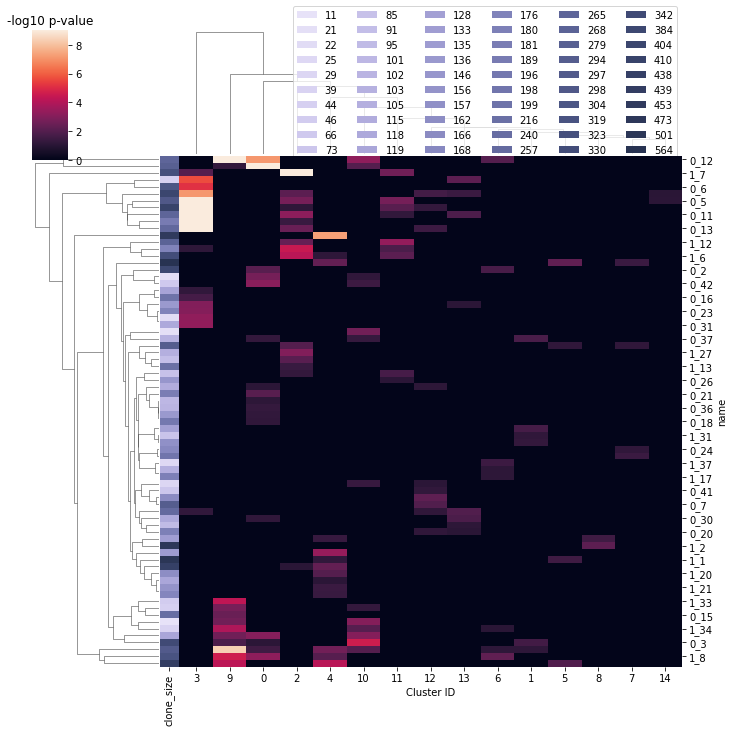

In [30]:
output_df=output_df.sort_values("size", ascending=True)
bh_enrichment_df[bh_enrichment_df>p_thresh] = 1
bh_enrichment_df[bh_enrichment_df==0] = min(p_thresh,min(set((bh_enrichment_df.values).flatten())-{0})) # Set to the next min, or p_thresh, whichever is smaller

anno_labels = np.sort(output_df["size"].unique())

anno_pal = sns.cubehelix_palette(len(anno_labels),
                                    light=.9, dark=.2, reverse=False,
                                    rot=.1, start=2.8)
anno_lut = dict(zip(map(str, anno_labels), anno_pal))

anno_colors = pd.Series(anno_lut)
anno_colors

output_df["clone_size"] = output_df["size"].apply(lambda x: anno_colors.loc[str(x)])


g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
                   row_cluster=True, row_colors=output_df[["clone_size"]])
g.ax_heatmap.set(xlabel="Cluster ID")
g.ax_cbar.set(title="-log10 p-value")

for label in anno_labels:
    g.ax_col_dendrogram.bar(0, 0, color=anno_lut[str(label)],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="right", ncol=6)
#g.cax.set_position([.15, .2, .03, .45])
plt.savefig(out_f+".png")